# Lets See How The Disc Models Preformed

This notebook is designed to analyze the disc models performance and to answer the question does Long Short Term Memory Neural Net (LSTM) outperform SparseLogisticRegression (SLR).

## MUST RUN AT THE START OF EVERYTHING

Load the database and other helpful functions for analysis.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import csv
import os

import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import seaborn as sns
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc, f1_score
import tqdm

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.annotations import FeatureAnnotator, LabelAnnotator, load_marginals
from snorkel.learning import SparseLogisticRegression
from snorkel.learning.disc_models.rnn import reRNN
from snorkel.learning.utils import RandomSearch
from snorkel.models import Candidate, FeatureKey, candidate_subclass
from snorkel.utils import get_as_dict
from snorkel.viewer import SentenceNgramViewer
from tree_structs import corenlp_to_xmltree
from treedlib import compile_relation_feature_generator

In [4]:
edge_type = "dg"

In [5]:
if edge_type == "dg":
    DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])
elif edge_type == "gg":
    GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])
elif edge_type == "cg":
    CompoundGene = candidate_subclass('CompoundGene', ['Compound', 'Gene'])
elif edge_type == "cd":
    CompoundDisease = candidate_subclass('CompoundDisease', ['Compound', 'Disease'])
else:
    print("Please pick a valid edge type")

# Load the data

Here is where we load the test dataset in conjunction with the previously trained disc models. Each algorithm will output a probability of a candidate being a true candidate.

In [6]:
featurizer = FeatureAnnotator()
labeler = LabelAnnotator(lfs=[])

In [7]:
%%time
L_test = labeler.load_matrix(session,split=2)
F_test = featurizer.load_matrix(session, split=2)

3830137it [00:06, 609431.32it/s]
245093197it [06:50, 597029.32it/s]


CPU times: user 8min 30s, sys: 1min 30s, total: 10min 1s
Wall time: 10min


In [8]:
model_marginals = pd.read_csv("Experiment 1/disc_marginals.csv")

# Grab the features of the Logistic Regression Model
lr_df = pd.read_csv("Experiment 1/LR_model.csv")

# Accuracy ROC

From the probabilities calculated above, we can create a [Receiver Operator Curve](http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html) (ROC) graph to measure the false positive rate and the true positive rate at each calculated threshold.

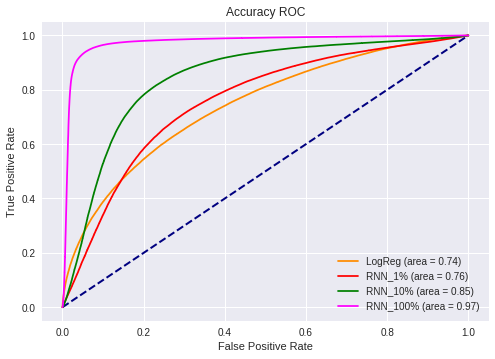

In [9]:
models = ["LR_Marginals", "RNN_1_Marginals", "RNN_10_Marginals", "RNN_Full_Marginals"]
model_colors = ["darkorange", "red", "green", "magenta"]
model_labels = ["LogReg", "RNN_1%", "RNN_10%", "RNN_100%"]
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

for model_label, marginal_label, color in zip(model_labels, models, model_colors):
    fpr, tpr, _= roc_curve(model_marginals["True Labels"], model_marginals[marginal_label])
    model_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, label="{} (area = {:0.2f})".format(model_label, model_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Accuracy ROC')
plt.legend(loc="lower right")

# Precision vs Recall Curve

This code produces a [Precision-Recall](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html) graph, which shows the trade off between [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) at each given probability threshold.

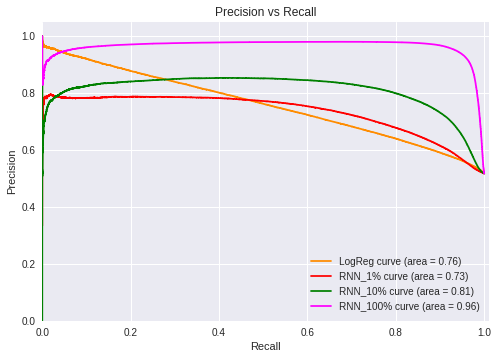

In [10]:
models = ["LR_Marginals", "RNN_1_Marginals", "RNN_10_Marginals", "RNN_Full_Marginals"]
model_colors = ["darkorange", "red", "green", "magenta"]
model_labels = ["LogReg", "RNN_1%", "RNN_10%", "RNN_100%"]

for model_label, marginal_label, color in zip(model_labels, models, model_colors):
    precision, recall, _ = precision_recall_curve(model_marginals["True Labels"], model_marginals[marginal_label])
    model_precision = average_precision_score(model_marginals["True Labels"], model_marginals[marginal_label])
    plt.plot(recall, precision, color=color, label="{} curve (area = {:0.2f})".format(model_label, model_precision))

plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision vs Recall')
plt.xlim([0, 1.01])
plt.ylim([0, 1.05])
plt.legend(loc="lower right")

# Error Analysis

This code shows the amount of true positives, false positives, true negatives and false negatives.

In [11]:
result_category = "fp"
if result_category == "tp":
    lr_cond = (model_marginals["LR_Predictions"] == 1)&(model_marginals["True Labels"] == 1)
    rnn1_cond = (model_marginals["RNN_1_Predictions"] == 1)&(model_marginals["True Labels"] == 1)
    rnn10_cond = (model_marginals["RNN_10_Predictions"] == 1)&(model_marginals["True Labels"] == 1)
    rnn100_cond = (model_marginals["RNN_Full_Predictions"] == 1)&(model_marginals["True Labels"] == 1)
elif result_category == "fp":
    lr_cond = (model_marginals["LR_Predictions"] == 1)&(model_marginals["True Labels"] == -1)
    rnn1_cond = (model_marginals["RNN_1_Predictions"] == 1)&(model_marginals["True Labels"] == -1)
    rnn10_cond = (model_marginals["RNN_10_Predictions"] == 1)&(model_marginals["True Labels"] == -1)
    rnn100_cond = (model_marginals["RNN_Full_Predictions"] == 1)&(model_marginals["True Labels"] == -1)
elif result_category == "tn":
    lr_cond = (model_marginals["LR_Predictions"] == -1)&(model_marginals["True Labels"] == -1)
    rnn1_cond = (model_marginals["RNN_1_Predictions"] == -1)&(model_marginals["True Labels"] == -1)
    rnn10_cond = (model_marginals["RNN_10_Predictions"] == -1)&(model_marginals["True Labels"] == -1)
    rnn100_cond = (model_marginals["RNN_Full_Predictions"] == -1)&(model_marginals["True Labels"] == -1)
elif result_category == "fn":
    lr_cond = (model_marginals["LR_Predictions"] == -1)&(model_marginals["True Labels"] == 1)
    rnn1_cond = (model_marginals["RNN_1_Predictions"] == -1)&(model_marginals["True Labels"] == 1)
    rnn10_cond = (model_marginals["RNN_10_Predictions"] == -1)&(model_marginals["True Labels"] == 1)
    rnn100_cond = (model_marginals["RNN_Full_Predictions"] == -1)&(model_marginals["True Labels"] == 1)
else:
    print ("Please re-run cell with correct options")

In [12]:
display_columns = ["LR_Marginals", "RNN_1_Marginals", "RNN_10_Marginals", "RNN_Full_Marginals", "True Labels"]

## LR

In [13]:
model_marginals[lr_cond].sort_values("LR_Marginals", ascending=False).head(10)[display_columns]

,LR_Marginals,RNN_1_Marginals,RNN_10_Marginals,RNN_Full_Marginals,True Labels
197694,0.990928,0.066495,0.925676,0.117871,-1
113204,0.987897,0.898082,0.158669,0.927670,-1
214333,0.985934,0.846595,0.076341,0.082633,-1
277240,0.984190,0.869162,0.917047,0.093191,-1
97033,0.982826,0.921902,0.929144,0.098238,-1
197699,0.982079,0.056412,0.935883,0.128485,-1
328074,0.979753,0.924814,0.898678,0.852160,-1
113199,0.978993,0.897975,0.903629,0.087491,-1
261382,0.977823,0.914170,0.875579,0.079410,-1
299327,0.976865,0.841053,0.914301,0.080187,-1


In [14]:
cand_index = list(model_marginals[lr_cond].sort_values("LR_Marginals", ascending=False).head(10).index)
lr_cands = [L_test.get_candidate(session, i) for i in cand_index]

In [15]:
print "Category: {}".format(result_category)
print 
for cand, cand_ind in zip(lr_cands, cand_index):
    text = cand[0].get_parent().text
    text = re.sub(cand[0].get_span().replace(")", "\)"), "--[[{}]]D--".format(cand[0].get_span()), text)
    text = re.sub(cand[1].get_span().replace(")", "\)"), "--[[{}]]G--".format(cand[1].get_span()), text)
    print cand_ind
    print "Candidate: ", cand
    print
    print "Text: \"{}\"".format(text)
    print
    print "--------------------------------------------------------------------------------------------"
    print

Category: fp

197694
Candidate:  DiseaseGene(Span("hypertensive disorders", sentence=64199313, chars=[150,171], words=[22,23]), Span("tumor necrosis factor-alpha receptor-1", sentence=64199313, chars=[384,421], words=[60,63]))

Text: "OBJECTIVES: To investigate whether the maternal serum concentration of activin A at 11-13 weeks of gestation in pregnancies that subsequently develop --[[hypertensive disorders]]D-- is different from those with a normal outcome and to examine whether any possible differences are related to uterine artery pulsatility index (PI), serum pregnancy-associated plasma protein A (PAPP-A) and serum --[[tumor necrosis factor-alpha receptor-1]]G-- (TNF-R1)."

--------------------------------------------------------------------------------------------

113204
Candidate:  DiseaseGene(Span("metabolic syndrome X.", sentence=44304040, chars=[145,165], words=[31,33]), Span("renin-angiotensin", sentence=44304040, chars=[372,388], words=[66,66]))

Text: "The role of I(1)-im

In [16]:
F_cand_index = 137865
print "Confidence Level: ", model_marginals["LR_Marginals"][F_cand_index]

Confidence Level:  0.499998152256


In [17]:
F_cand_index = 137865
lr_df.iloc[F_test[F_cand_index, :].nonzero()[1]].sort_values("Weight", ascending=False)

,Weight,Feature
2294,0.129688,TDL_INV_LEMMA:BETWEEN-MENTION-and-MENTION[secr...
1035599,0.123572,TDL_INV_LEMMA:SEQ-BETWEEN[angiogenesis in]
2306,0.114284,TDL_INV_LEMMA:SEQ-BETWEEN[secretion]
197439,0.111293,TDL_INV_LEMMA:SEQ-BETWEEN[vegf]
4042,0.110235,"TDL_INV_LEMMA:SEQ-BETWEEN[growth ,]"
1035595,0.096452,TDL_INV_DEP_LABEL|LEMMA:BETWEEN-MENTION-and-ME...
4942215,0.080568,"TDL_INV_LEMMA:SEQ-BETWEEN[, tumor growth]"
11112790,0.072525,TDL_INV_LEMMA:BETWEEN-MENTION-and-MENTION[secr...
4204575,0.070468,"TDL_INV_LEMMA:SEQ-BETWEEN[, and angiogenesis]"
1421643,0.069333,TDL_INV_LEMMA:SEQ-BETWEEN[and angiogenesis in]


In [18]:
cand = session.query(Candidate).filter(Candidate.id == L_test.get_candidate(session, 137865).id).one()
print cand
xmltree = corenlp_to_xmltree(get_as_dict(cand.get_parent()))
xmltree.render_tree(highlight=[range(cand[0].get_word_start(), cand[0].get_word_end() + 1), range(cand[1].get_word_start(), cand[1].get_word_end()+1)])

DiseaseGene(Span("malignant gliomas", sentence=51208076, chars=[90,106], words=[16,17]), Span("HIF-1alpha", sentence=51208076, chars=[26,35], words=[5,5]))


<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 We examined the effect of HIF-1alpha on VEGF secretion , tumor growth , and angiogenesis in malignant gliomas .

## LSTM 1% Sub-Sampling

In [19]:
model_marginals[rnn1_cond].sort_values("RNN_1_Marginals", ascending=False).head(10)[display_columns]

,LR_Marginals,RNN_1_Marginals,RNN_10_Marginals,RNN_Full_Marginals,True Labels
330145,0.618106,0.951367,0.102306,0.104462,-1
330139,0.570315,0.951012,0.873574,0.127814,-1
187491,0.418565,0.950715,0.082267,0.080301,-1
187497,0.320465,0.950424,0.071110,0.080136,-1
187501,0.481045,0.950030,0.071029,0.082925,-1
280556,0.667316,0.949813,0.910082,0.917518,-1
150900,0.675697,0.948304,0.085299,0.883467,-1
59801,0.689764,0.948254,0.916327,0.191260,-1
98502,0.238132,0.947687,0.884443,0.073906,-1
95567,0.618838,0.947633,0.379297,0.084653,-1


In [20]:
cand_index = list(model_marginals[rnn1_cond].sort_values("RNN_1_Marginals", ascending=False).head(10).index)
lr_cands = [L_test.get_candidate(session, i) for i in cand_index]

In [21]:
print "Category: {}".format(result_category)
print 
for cand in lr_cands:
    text = cand[0].get_parent().text
    text = re.sub(cand[0].get_span().replace(")", "\)"), "--[[{}]]D--".format(cand[0].get_span()), text)
    text = re.sub(cand[1].get_span().replace(")", "\)"), "--[[{}]]G--".format(cand[1].get_span()), text)
    print "Candidate: ", cand
    print
    print "Text: \"{}\"".format(text)
    print
    print "--------------------------------------------------------------------------------------------"
    print

Category: fp

Candidate:  DiseaseGene(Span("prostate cancer", sentence=92020903, chars=[18,32], words=[2,3]), Span("CHD1-loss", sentence=92020903, chars=[149,157], words=[16,16]))

Text: "Classification of --[[prostate cancer]]D-- into distinct molecular subtypes, including mutually exclusive ETS-gene-fusion-positive and SPINK1-overexpressing, --[[CHD1-loss]]G-- cancers, could allow stratification of patients for different management strategies."

--------------------------------------------------------------------------------------------

Candidate:  DiseaseGene(Span("prostate cancer", sentence=92020903, chars=[18,32], words=[2,3]), Span("SPINK1-overexpressing", sentence=92020903, chars=[126,146], words=[14,14]))

Text: "Classification of --[[prostate cancer]]D-- into distinct molecular subtypes, including mutually exclusive ETS-gene-fusion-positive and --[[SPINK1-overexpressing]]G--, CHD1-loss cancers, could allow stratification of patients for different management strategies."

----

## LSTM 10% Sub-Sampling

In [22]:
model_marginals[rnn10_cond].sort_values("RNN_10_Marginals", ascending=False).head(10)[display_columns]

,LR_Marginals,RNN_1_Marginals,RNN_10_Marginals,RNN_Full_Marginals,True Labels
7050,0.256613,0.877740,0.961949,0.456342,-1
296135,0.501503,0.925820,0.958400,0.869161,-1
182862,0.415044,0.919522,0.956646,0.114303,-1
182868,0.429325,0.920251,0.956345,0.097459,-1
75847,0.628306,0.083975,0.955706,0.099154,-1
182858,0.303995,0.918555,0.954360,0.086512,-1
330321,0.434651,0.929890,0.954085,0.101265,-1
179043,0.276681,0.165298,0.953363,0.120148,-1
7043,0.496409,0.892785,0.952899,0.100910,-1
179057,0.162308,0.112732,0.952671,0.088962,-1


In [23]:
cand_index = list(model_marginals[rnn10_cond].sort_values("RNN_10_Marginals", ascending=False).head(10).index)
lr_cands = [L_test.get_candidate(session, i) for i in cand_index]

In [24]:
print "Category: {}".format(result_category)
print 
for cand in lr_cands:
    text = cand[0].get_parent().text
    text = re.sub(cand[0].get_span().replace(")", "\)"), "--[[{}]]D--".format(cand[0].get_span()), text)
    text = re.sub(cand[1].get_span().replace(")", "\)"), "--[[{}]]G--".format(cand[1].get_span()), text)
    print "Candidate: ", cand
    print
    print "Text: \"{}\"".format(text)
    print
    print "--------------------------------------------------------------------------------------------"
    print

Category: fp

Candidate:  DiseaseGene(Span("psoriasis", sentence=4813161, chars=[37,45], words=[8,8]), Span("PRL-skin", sentence=4813161, chars=[99,106], words=[18,18]))

Text: "Centering on the role of PRL in both --[[psoriasis]]D-- and hair growth as models for studying the proposed --[[PRL-skin]]G-- connection, clinical and experimental evidence in support of this theory is discussed in the context of a 'neuroimmune-dermatological' perspective."

--------------------------------------------------------------------------------------------

Candidate:  DiseaseGene(Span("PE", sentence=85288022, chars=[132,133], words=[20,20]), Span("fibrinogen-TLR4", sentence=85288022, chars=[30,44], words=[5,5]))

Text: "Our findings suggest that the --[[fibrinogen-TLR4]]G-- axis might play an important role in the atypical activation of monocytes observed in --[[PE]]D-- patients that may contribute to the exaggerated inflammatory condition."

----------------------------------------------------------

# FULL LSTM

In [25]:
model_marginals[rnn100_cond].sort_values("RNN_Full_Marginals", ascending=False).head(10)[display_columns]

,LR_Marginals,RNN_1_Marginals,RNN_10_Marginals,RNN_Full_Marginals,True Labels
177203,0.639844,0.913547,0.094610,0.953752,-1
340309,0.452486,0.841224,0.882283,0.953156,-1
43786,0.492735,0.122623,0.902084,0.952902,-1
202358,0.636795,0.477295,0.142493,0.952474,-1
161394,0.380008,0.086032,0.903802,0.951762,-1
199947,0.473632,0.828220,0.080000,0.951191,-1
139624,0.308701,0.711390,0.911962,0.950896,-1
161410,0.413354,0.086063,0.904500,0.949873,-1
139635,0.320040,0.706530,0.910923,0.948485,-1
171502,0.397804,0.905576,0.887405,0.948364,-1


In [26]:
cand_index = list(model_marginals[rnn100_cond].sort_values("RNN_Full_Marginals", ascending=False).head(10).index)
lr_cands = [L_test.get_candidate(session, i) for i in cand_index]

In [27]:
print "Category: {}".format(result_category)
print 
for cand in lr_cands:
    text = cand[0].get_parent().text
    text = re.sub(cand[0].get_span().replace(")", "\)"), "--[[{}]]D--".format(cand[0].get_span()), text)
    text = re.sub(cand[1].get_span().replace(")", "\)"), "--[[{}]]G--".format(cand[1].get_span()), text)
    print "Candidate: ", cand
    print
    print "Text: \"{}\"".format(text)
    print
    print "--------------------------------------------------------------------------------------------"
    print

Category: fp

Candidate:  DiseaseGene(Span("PsA", sentence=60172972, chars=[92,94], words=[14,14]), Span("MICA-A5", sentence=60172972, chars=[322,328], words=[55,55]))

Text: "RESULTS: MICA-TM microsatellite typing revealed that, among the different clinical forms of --[[PsA]]D--, only the combined PA/SP subset shows a significant positive association with MICA-A9 and a lower frequency of MICA-A4, A5 genotype in --[[PsA]]D-- patients with a decrease, only in the PA/SP cohort, of all --[[MICA-A5]]G-- combinations except --[[MICA-A5]]G--, -A9."

--------------------------------------------------------------------------------------------

Candidate:  DiseaseGene(Span("depressive symptoms", sentence=94465345, chars=[67,85], words=[14,15]), Span("IL-1b", sentence=94465345, chars=[144,148], words=[27,27]))

Text: "RESULTS: Thirty-six (40%) of 89 patients showed elevated levels of --[[depressive symptoms]]D-- and, in adjusted models, had marginally higher levels of --[[IL-1b]]G-- (mean [M] = 

# Write Results to TSV

In [ ]:
field_names = ["Disease ID", "Disease Char Start", "Disease Char End", "Gene ID", "Gene Char Start", "Gene Char End", "Sentence", "Prediction"]
with open("LSTM_results.tsv", "w") as f:
    writer = csv.DictWriter(f, fieldnames=field_names)
    writer.writeheader()
    for i in tqdm.tqdm(model_marginals.index):
        cand = L_test.get_candidate(session, i)
        row = {
                "Disease ID": cand.Disease_cid, "Disease Char Start":cand[0].char_start, 
                "Disease Char End": cand[0].char_end, "Gene ID": cand.Gene_cid, 
                "Gene Char Start":cand[1].char_start, "Gene Char End":cand[1].char_end, 
                "Sentence": cand.get_parent().text, "Prediction": model_marginals.iloc[i]["RNN_Full_Marginals"]}
        writer.writerow(row)